In [1]:
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,

    RegressionScore,
)
from metrics.utils import post_process
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models import (
    LeastSquaresModel,
    RetrievalDictModel,
    ZeroModel,
    GDModel,
)

from interactive import load_checkpoint_with_config

from function_classes.mlp import MLPRegression
from function_classes.decision_tree import DecisionTreeRegression
from function_classes.linear import LinearRegression, SparseLinearRegression
from function_classes.retrieval import Retrieval

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch

In [6]:
NUM_BATCHES, B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 128, 512, 41, 20, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

# RUNS = [
#     "linear mamba", # vocab=1, pos=141
#     "linear gpt2 (rms rope)", # vocab=1, pos=141
#     "linear gpt2 (rope ffn)", # vocab=1, pos=141
#     "linear llama (rope ffn)", # vocab=1, pos=141
#     "linear llama (rope)", # vocab=1, pos=141
#     "linear llama (ffn)", # vocab=1, pos=141
#     "linear gpt2 (rope)", # vocab=1, pos=141

#     # "linear gpt2 (ffn)", # vocab=1, pos=101
#     # "linear gpt2 (rms)", # vocab=1, pos=101
#     # "linear gpt2 (rms ffn)", # vocab=1, pos=101
#     # "linear gpt2", # vocab=default, pos=101

#     # "linear llama", # vocab=default, pos=141
# ]

RUNS = [
    # "dt mamba", # vocab=1, pos=141
    # "dt gpt2 (rms rope)", # vocab=1, pos=141
    # "dt gpt2 (rope ffn)", # vocab=1, pos=141
    # "dt llama (rope ffn)", # vocab=1, pos=141
    # "dt llama (rope)", # vocab=1, pos=141
    # "dt llama (ffn)", # vocab=1, pos=141
    # "dt gpt2 (rope)", # vocab=1, pos=141

    # "dt gpt2 (ffn)", # vocab=1, pos=101
    # "dt gpt2 (rms)", # vocab=1, pos=101
    # "dt gpt2 (rms ffn)", # vocab=1, pos=101
    # "dt gpt2", # vocab=1, pos=101

    # "dt llama", # vocab=default, pos=101
]

RUNS = [
    "sparse mamba", # vocab=1, pos=141
    "sparse gpt2 (rms rope)", # vocab=1, pos=141
    "sparse gpt2 (rope ffn)", # vocab=1, pos=141
    "sparse llama (rope ffn)", # vocab=1, pos=141
    "sparse llama (rope)", # vocab=1, pos=141
    "sparse llama (ffn)", # vocab=1, pos=141
    "sparse gpt2 (rope)", # vocab=1, pos=141

    # "sparse gpt2 (ffn)", # vocab=1, pos=101
    # "sparse gpt2 (rms)", # vocab=1, pos=101
    # "sparse gpt2 (rms ffn)", # vocab=1, pos=101
    # "sparse gpt2", # vocab=default, pos=101

    # "sparse llama", # vocab=1, pos=141
]

# RUNS = [
#     "mlp mamba", # vocab=1, pos=141                   # MODELS3
#     "mlp gpt2 (rms rope)", # vocab=1, pos=141
#     "mlp gpt2 (rope ffn)", # vocab=1, pos=141
#     "mlp llama (rope ffn)", # vocab=1, pos=141
#     "mlp llama (rope)", # vocab=1, pos=141
#     "mlp llama (ffn)", # vocab=1, pos=141
#     "mlp gpt2 (rope)", # vocab=1, pos=141

#     # "mlp gpt2 (ffn)", # vocab=1, pos=101               # MODELS2
#     # "mlp gpt2 (rms)", # vocab=1, pos=101
#     # "mlp gpt2 (rms ffn)", # vocab=1, pos=101

#     # "mlp gpt2", # vocab=default, pos=101                    # MODELS1
#     # "mlp llama", # vocab=default, pos=101
# ]

# RUNS = """
# linear llama (rope ffn)
# linear llama (rope)
# linear llama (ffn)
# linear mamba
# linear gpt2 (ffn)
# linear gpt2 (rope)
# linear gpt2 (rms)
# linear gpt2 (rms ffn)
# linear gpt2 (rms rope)
# linear gpt2 (rope ffn)
# linear gpt2
# linear llama
# """.strip().split("\n")

CHECKPOINTS = list(map(lambda mod: f"../checkpoints/{mod}/models/checkpoint_500000", RUNS))

CONFIGS = list(map(
    lambda run: "_".join(
        run.strip()
           .replace('(', '')
           .replace(')', '')
           .replace(' ', '_')
           .split("_")[1:]
        ),
    RUNS
))

CONFIGS = list(map(lambda mod: f"../conf/train/{mod}/linear_regression.yml", CONFIGS))

In [3]:
MODELS1 = [
    # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    *[
        # (print(conf), load_checkpoint_with_config(conf, chk_path))
        load_checkpoint_with_config(conf, chk_path)
        for conf, chk_path in zip(CONFIGS, CHECKPOINTS)
    ]
]

In [5]:
MODELS2 = [
    # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    *[
        # (print(conf), load_checkpoint_with_config(conf, chk_path))
        load_checkpoint_with_config(conf, chk_path)
        for conf, chk_path in zip(CONFIGS, CHECKPOINTS)
    ]
]

In [7]:
MODELS3 = [
    # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    *[
        # (print(conf), load_checkpoint_with_config(conf, chk_path))
        load_checkpoint_with_config(conf, chk_path)
        for conf, chk_path in zip(CONFIGS, CHECKPOINTS)
    ]
]

In [8]:
MODELS = MODELS3 + MODELS2 + MODELS1

In [9]:
MODELS_DICT = {
   "Mamba" : MODELS[0],
   "GPT-2 RMS RoPE" : MODELS[1],
   "GPT-2 RoPE SwiGLU" : MODELS[2],
   "Llama RoPE,SwiGLU-less" : MODELS[3],
   "Llama RoPE-less" : MODELS[4],
   "Llama SwiGLU-less" : MODELS[5],
   "GPT-2 RoPE" : MODELS[6],
   "GPT-2 SwiGLU" : MODELS[7],
   "GPT-2 RMS" : MODELS[8],
   "GPT-2 RMS SwiGLU" : MODELS[9],
   "GPT-2" : MODELS[10],
   "Llama" : MODELS[11],
}

In [10]:
SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

METRIC = SquaredError()

In [11]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim
# x_dist = RetrievalDistribution(torch.Size([B_SIZE, SEQ_LEN]), torch.Size([X_DIM]))

# base_fc = MLPRegression(hidden_dimension=100, x_distribution=x_dist, y_dim=Y_DIM)
base_fc = SparseLinearRegression(sparsity=3, x_distribution=x_dist, y_dim=Y_DIM)
# base_fc = Retrieval(x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

In [15]:
zero = ZeroModel(x_dim=X_DIM, y_dim=Y_DIM)
# baseline = GDModel('mlp', {'dimensions': [100]}, 'adam', 100, 100, 5e-3, x_dim=X_DIM, y_dim=Y_DIM)
# MODELS1 = [zero, baseline]
errs = bench.evaluate(MODELS_DICT.values(), num_batches=4)

In [7]:
reg_score = RegressionScore(METRIC, base_fc, torch.tensor(1000), 
    torch.load("optimal_errs/mlp_regression"))

In [8]:
scores, scores_std = reg_score.evaluate(MODELS, num_batches=NUM_BATCHES)

/home/ubuntu/in-context/src/metrics/score.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_err = torch.tensor(self.funct_err.evaluate(models, num_batches=num_batches))


In [9]:
from pprint import pprint
pprint(list(zip(MODELS, scores, scores_std)))

[(gpt2_embd=256_layer=12_head=8, tensor(14.6193), tensor(0.0060)),
 (llama_embd=256_layer=12_head=8, tensor(14.6025), tensor(0.0060))]


In [12]:
errs = bench.evaluate([m for m in MODELS_DICT.values()], num_batches=NUM_BATCHES).to('cpu')
values = list(post_process(errs))

In [13]:
GPT2_Llama_Archs = {
    "GPT-2" : 10,
    "GPT-2 RMS" : 8,
    "GPT-2 RoPE" : 6,
    "GPT-2 SwiGLU" : 7,
    "GPT-2 RMS SwiGLU" : 9,
    "GPT-2 RMS RoPE" : 1,
    "GPT-2 RoPE SwiGLU" : 2,
    "Llama" : 11
}

Llama_Mamba_Archs = {
    "Llama" : 11,
    "Llama RoPE-less" : 4,
    "Llama SwiGLU-less" : 5,
    "Llama RoPE,SwiGLU-less": 3,
    "Mamba": 0,
}

In [14]:
import numpy as np

GPT-2 10
GPT-2 RMS 8
GPT-2 RoPE 6
GPT-2 SwiGLU 7
GPT-2 RMS SwiGLU 9
GPT-2 RMS RoPE 1
GPT-2 RoPE SwiGLU 2
Llama 11


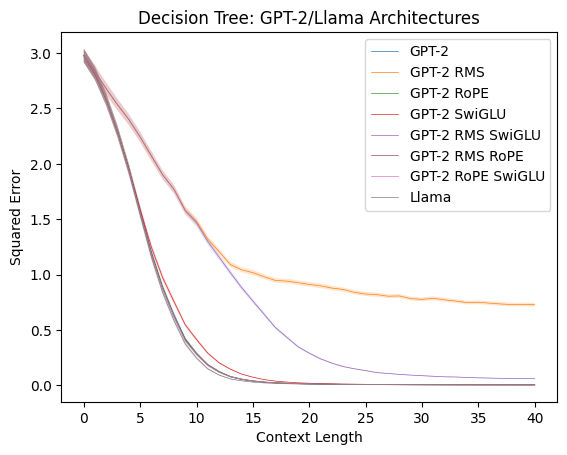

In [17]:
for model_k, model_idx in zip(GPT2_Llama_Archs.keys(), GPT2_Llama_Archs.values()):
    print(model_k, model_idx)
    accuracy = values[model_idx]['accuracy'].squeeze().tolist()
    lower_bound = (values[model_idx]['confidence_0.01_lower']).squeeze().tolist()
    upper_bound = (values[model_idx]['confidence_0.01_upper']).squeeze().tolist()
    plt.plot('accuracy', data=values[model_idx], label=f"{model_k}", linewidth=0.5)
    plt.fill_between(range(41), lower_bound, upper_bound, alpha=0.2)
plt.title("Sparse Linear: GPT-2/Llama Architectures")
plt.ylabel("Squared Error")
plt.xlabel("Context Length")
plt.legend()
plt.show()

Llama 11
Llama RoPE-less 4
Llama SwiGLU-less 5
Llama RoPE,SwiGLU-less 3
Mamba 0


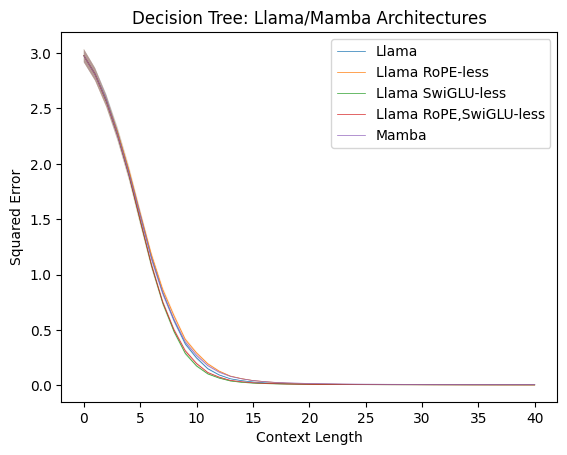

In [18]:
for model_k, model_idx in zip(Llama_Mamba_Archs.keys(), Llama_Mamba_Archs.values()):
    print(model_k, model_idx)
    accuracy = values[model_idx]['accuracy'].squeeze().tolist()
    lower_bound = (values[model_idx]['confidence_0.01_lower']).squeeze().tolist()
    upper_bound = (values[model_idx]['confidence_0.01_upper']).squeeze().tolist()
    plt.plot('accuracy', data=values[model_idx], label=f"{model_k}", linewidth=0.5)
    plt.fill_between(range(41), lower_bound, upper_bound, alpha=0.2)
plt.title("Sparse Linear: Llama/Mamba Architectures")
plt.ylabel("Squared Error")
plt.xlabel("Context Length")
plt.legend()
plt.show()

In [96]:
# for b in scaled_in_benches:
#     errs = b.evaluate(MODELS, num_batches=4)
#     values = list(post_process(errs))
#     for model, results in zip(MODELS, values):
#         plt.title(f"Errors for X scaled by {b.function_class._scale}")  # pyright: ignore[reportAttributeAccessIssue]
#         plt.plot("accuracy", data=results, label="accuracy")
#         plt.plot("confidence_0.01_upper", data=results)
#         plt.plot("confidence_0.01_lower", data=results)
#         plt.legend()
#         plt.show()
#         break

In [101]:
MODELS = [model for k, model in zip(MODELS_DICT.keys(), MODELS_DICT.values())]

In [102]:
bench = FCErrorQuadrants(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break


AssertionError: Produced wrong output shape in MLP function class!Expected: (512, 101, 1)Got: (512, 1, 1)

In [103]:
bench = FCErrorOrthogonal(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [100]:
bench = FCErrorSeenPoints(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    
    plt.legend()
    plt.show()
    break

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)